In [301]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import matplotlib.image as img
import seaborn as sns
import cv2
import scipy.stats as ss
from scipy.misc import toi
import scipy
from scipy.stats import entropy as scipy_entropy
from PIL import Image
import itertools
from functools import reduce
%matplotlib inline
plt.style.use('seaborn')

In [370]:
def jointTable(x, y):
    ones = np.ones((len(x)+1, len(y)+1))
    unique, counts = np.unique(x, return_counts=True)
    xdic = dict(zip(unique, counts))
    unique, counts = np.unique(y, return_counts=True)
    ydic = dict(zip(unique, counts))
    
    for i in range(len(x)+1):
        for j in range(len(y)+1):
            if (i+1 in xdic.keys() and j+1 in ydic.keys()):
                ones[j][i] = (xdic[i+1]/len(x)) * (ydic[i+1]/len(y))
            else:
                ones[j][i] = 0
    df = pd.DataFrame(ones)
    df['Marginal'] = df.sum(axis=1)
    df = df.T
    df['Marginal'] = df.sum(axis=1)
    df = df.T
    return df
df = jointTable([1,1,2,3,4,5,7,7], [1,1,2,3,4,5,7,1])

In [398]:
def splitImage(img):
    split_img = Image.Image.split(img)
    return split_img[0], split_img[1], split_img[2]

def shannon_entropy(image, base=2):
    _, counts = np.unique(image, return_counts=True)
    return scipy_entropy(counts, base=base)

def cropImage(img):
    r, g, b = splitImage(img)
    w, h = img.size
    top = r.crop((20, 0, w-20, h))
    return top, [g.crop((40-x, 0, w-x, h)) for x in range(40, -1, -1)]

def entropyCalc(X):
    probs = [np.mean(X == c) for c in set(X)]
    return sum(-p * np.log2(p) for p in probs)

def mutualInfoCalc(img, num_bins):
    top, bottoms = cropImage(img)
    mis = []
    for i in range(len(bottoms)):
        hist = np.histogram2d(np.asarray(top).flatten(), np.asarray(bottoms[i]).flatten(), bins=num_bins)
        hist_img = Image.fromarray(hist[0], 'RGB')
        mis.append(entropyCalc(np.asarray(top).flatten()) + entropyCalc(np.asarray(bottoms[i]).flatten()) - entropyCalc(np.asarray(hist_img).flatten()))
    return mis

def binSizeChange(img):
    top, bottoms = cropImage(img)
    mis = []
    for i in range(1, 256):
        hist = np.histogram2d(np.asarray(top).flatten(), np.asarray(bottoms[20]).flatten(), bins=int(256/i))
        hist_img = Image.fromarray(hist[0], 'RGB')
        mis.append(entropyCalc(np.asarray(top).flatten()) + entropyCalc(np.asarray(bottoms[20]).flatten()) - entropyCalc(np.asarray(hist_img).flatten()))
    return mis

In [374]:
img = Image.open("./section8-image.png")

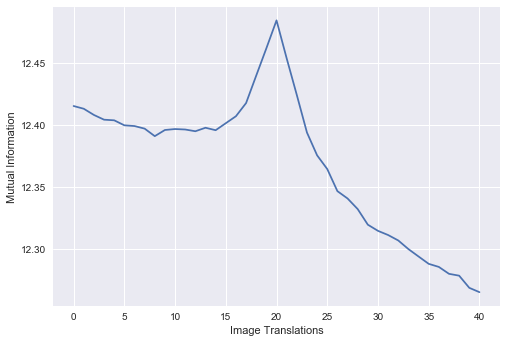

In [392]:
fig = plt.figure()
plt.ylabel('Mutual Information')
plt.xlabel('Image Translations')
sns.lineplot([x for x in range(41)], mutualInfoCalc(img, 256))

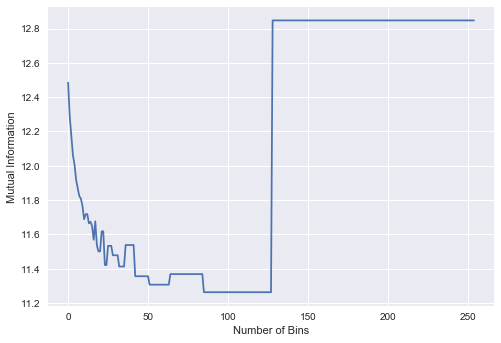

In [397]:
fig = plt.figure()
plt.ylabel('Mutual Information')
plt.xlabel('Number of Bins')
sns.lineplot([x for x in range(255)], binSizeChange(img))

In [361]:
hist = np.histogram2d(np.asarray(r).flatten(), np.asarray(g).flatten(), bins=256)
img = Image.fromarray(hist[0], 'RGB')
test = shannon_entropy(r) + shannon_entropy(g) - shannon_entropy(img)
test

12.667885244006321

In [371]:
def entropyDep(signal):
    len_sig = signal.size
    sym_set = list(set(signal))
    num_sym = len(sym_set)
    prob = [np.size(signal[signal==i])/(1.0*len_sig) for i in sym_set]
    ent = np.sum([p * np.log2(1.0/p) for p in prob])
    return ent

def getEntropy(binsize, img):
    N = binsize
    S = g.shape
    E = np.array(img)
    for row in range(S[0]):
        for col in range(S[1]):
            Lx=np.max([0,col-N])
            Ux=np.min([S[1],col+N])
            Ly=np.max([0,row-N])
            Uy=np.min([S[0],row+N])
            region=g[Ly:Uy,Lx:Ux].flatten()
            E[row,col]=entropyDep(region)
    return E

In [177]:
green = getEntropy(5, g)

KeyboardInterrupt: 

In [ ]:
red = getEntropy(5, r)

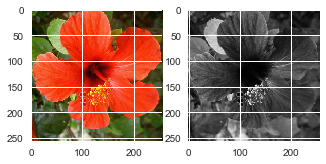

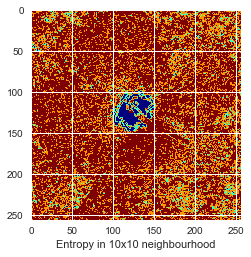

In [183]:
plt.subplot(1,3,1)
plt.imshow(img)

plt.subplot(1,3,2)
plt.imshow(g, cmap=plt.cm.gray)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1,3,3)
plt.imshow(rip, cmap=plt.cm.jet)
plt.xlabel('Entropy in 10x10 neighbourhood')
plt.tight_layout()
plt.show()

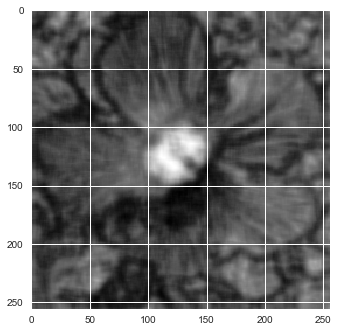

In [178]:
plt.imshow(rip)

In [365]:
x = (red + green) - rip